In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank
from skimage.filters import threshold_mean, threshold_local
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing, binary_dilation, binary_erosion

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


## Alternative IQR approach

In [2]:
def crop_number(input_src):
    return input_src[310:310+100, 300:300+330]

def projectionVer(input_img):
    return np.sum(input_img, axis=1)/255

def projectionHor(input_img):
    return np.sum(input_img, axis=0)/255

def threshold(input_img):
    # gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8,8))
    clh = clahe.apply(cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY))
   
    _, trunc = cv2.threshold(clh, 100, 255, cv2.THRESH_TRUNC)
    blurred = cv2.bilateralFilter(trunc, 6, 25, 25)
    return cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)

In [3]:
def display_single_tests():
    fig, ax = plt.subplots(2, 4, figsize=(40, 5), sharex=True, sharey=True)
    ax = ax.ravel()

    ax[0].imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    ax[1].set_title('Thresholded')
    ax[1].axis('off')

    ax[2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    ax[2].set_title('Contoured')
    ax[2].axis('off')

    ax[3].imshow(cv2.cvtColor(good_mask, cv2.COLOR_GRAY2RGB))
    ax[3].set_title('Good Mask')
    ax[3].axis('off')

    ax[4].imshow(cv2.cvtColor(graphicHor, cv2.COLOR_GRAY2RGB))
    ax[4].set_title('graphicHor')
    ax[4].axis('off')
    
    ax[5].imshow(cv2.cvtColor(graphicVer, cv2.COLOR_GRAY2RGB))
    ax[5].set_title('graphicVer')
    ax[5].axis('off')

    ax[6].imshow(cv2.cvtColor(contours2, cv2.COLOR_BGR2RGB))
    ax[6].set_title('contours2')
    ax[6].axis('off')

    ax[7].imshow(cv2.cvtColor(source_copy, cv2.COLOR_BGR2RGB))
    ax[7].set_title('')
    ax[7].axis('off')

    #ax[7].imshow(cv2.cvtColor(dilated[tly:rby, tlx:rbx], cv2.COLOR_GRAY2RGB))
    #ax[7].set_title('Number Zone')
    #ax[7].axis('off')

In [14]:
# excise_src = cv2.imread("data/monitor/_1521540786569_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540617554_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540917583_capture.png")

excise_src = cv2.imread("data/monitor/_1521541525082_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540642840_capture.png")

# excise_src = cv2.imread("data/monitor/_1521540926209_capture.png")

# excise_src = cv2.imread("data/monitor/_1521540643837_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540628560_capture.png")
# excise_src = cv2.imread("data/monitor/_1521540613851_capture.png")

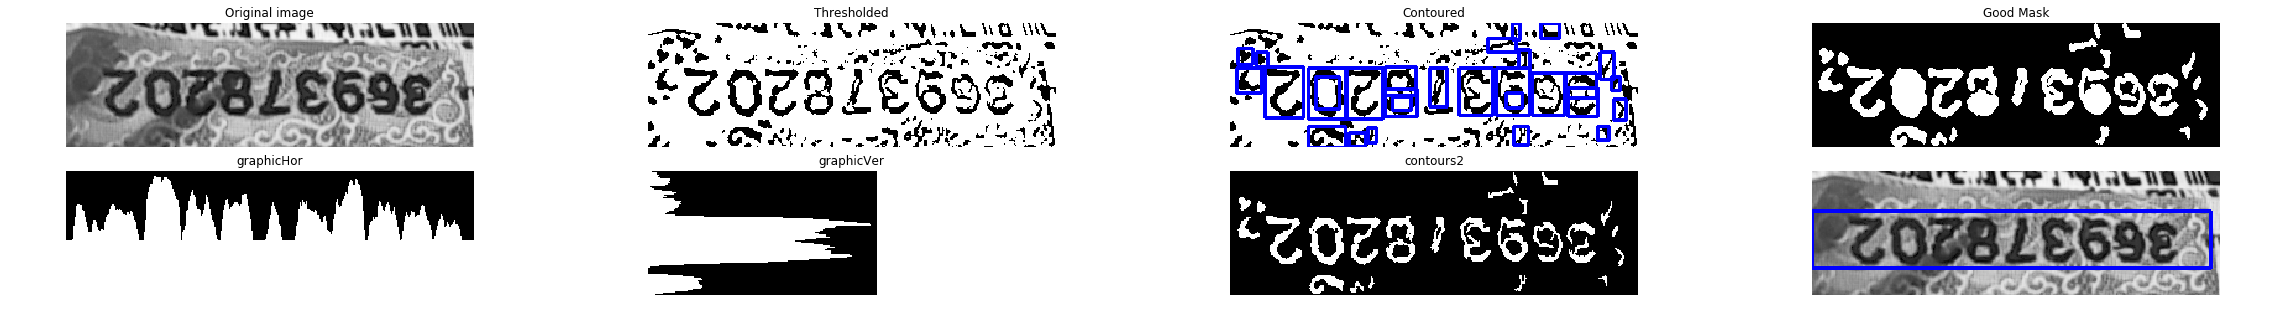

In [15]:
number = crop_number(excise_src)
thresholded = threshold(number)

edged = cv2.Canny(thresholded, 30, 200)
width, height = thresholded.shape[:2]

refCnts = cv2.findContours(thresholded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]

# For Visualisation
contours = np.dstack([thresholded.copy()] * 3)
contours2 = np.dstack([thresholded.copy()] * 3)
source_copy = number.copy()

good_mask = np.ones(thresholded.shape[:2], dtype="uint8") * 0
good_mask_candidates = []

for c in refCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if (w < 100) and (h > 10) and (w > 5) and (h < 90):
        good_mask_candidates.append((x, y, w, h))
        cv2.drawContours(good_mask, [c], -1, 255, -1)
        # For Visualisation
        cv2.rectangle(contours, (x, y), (x + w, y + h), (255, 0, 0), 2)
           
verp = projectionVer(good_mask)
peak = np.amax(verp)
topline = 0
bottomline = 0
for i in range(len(verp)):
    if verp[i] > peak*0.5:
        if topline == 0:
            topline = i-1
        if bottomline < i+1:
            bottomline = i+1

leftline = 0
rightline = 0
for (x, y, w, h) in good_mask_candidates: # c[0, 1, 2, 3] --> (x, y, w, h)
    if ((y+h > topline) or (y < bottomline)) and (topline - y < 20) and (y+h - bottomline < 20) and (w*h > 200):
        if (leftline == 0) or (x < leftline):
            leftline = x
        if rightline < x+w:
            rightline = x+w
        # For Visualisation
        cv2.rectangle(contours2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        

topline = topline-4 if topline > 4 else 0
bottomline = bottomline+4 if bottomline < 96 else 100
leftline = leftline-12 if leftline > 12 else 0
rightline = rightline+12 if rightline < 318 else 330

# For Visualisation
cv2.rectangle(source_copy, (int(leftline), int(topline)), (int(rightline), int(bottomline)), (255, 0, 0), 2)

# For Visualisation
horp = projectionHor(good_mask)
    
horp2 = horp.astype(int)
h = int(np.max(horp2) + 5)
graphicHor = np.zeros((h, good_mask.shape[1]), dtype = "uint8")

for i in range(len(horp2)):
    graphicHor[int(graphicHor.shape[0]-horp2[i]):graphicHor.shape[0], i] = 255
            
verp2 = verp.astype(int)
w = np.max(verp2) + 5
graphicVer = np.zeros((good_mask.shape[0], w), dtype = "uint8")

for i in range(len(verp2)):
    graphicVer[i, 0:verp2[i]] = 255
    
thresholded_inv = cv2.bitwise_not(thresholded)
contours_filtered = cv2.bitwise_and(thresholded_inv, thresholded_inv, mask=good_mask)
colored_contours_filtered = cv2.cvtColor(cv2.bitwise_not(contours_filtered), cv2.COLOR_GRAY2BGR)
contours2 = np.dstack([contours_filtered.copy()] * 3)
        
display_single_tests()

## Tests

In [11]:
def segment_mumber(excise_src):
    
    number = crop_number(excise_src)
    thresholded = threshold(number)

    edged = cv2.Canny(thresholded, 30, 200)
    width, height = thresholded.shape[:2]

    refCnts = cv2.findContours(thresholded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]

    # For Visualisation
    contours = np.dstack([thresholded.copy()] * 3)
    source_copy = number.copy()

    good_mask = np.ones(thresholded.shape[:2], dtype="uint8") * 0
    good_mask_candidates = []

    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if (w < 100) and (h > 10) and (w > 5) and (h < 90):
            good_mask_candidates.append((x, y, w, h))
            cv2.drawContours(good_mask, [c], -1, 255, -1)
            # For Visualisation
            cv2.rectangle(contours, (x, y), (x + w, y + h), (255, 0, 0), 2)

    verp = projectionVer(good_mask)
    peak = np.amax(verp)
    topline = 0
    bottomline = 0
    for i in range(len(verp)):
        if verp[i] > peak*0.5:
            if topline == 0:
                topline = i-1
            if bottomline < i+1:
                bottomline = i+1

    leftline = 0
    rightline = 0
    for (x, y, w, h) in good_mask_candidates: # c[0, 1, 2, 3] --> (x, y, w, h)
        if ((y+h > topline) or (y < bottomline)) and (topline - y < 20) and (y+h - bottomline < 20) and (w*h > 200):
            if (leftline == 0) or (x < leftline):
                leftline = x
            if rightline < x+w:
                rightline = x+w
            # For Visualisation
            cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)


    topline = topline-8 if topline > 8 else 0
    bottomline = bottomline+4 if bottomline < 96 else 100
    leftline = leftline-8 if leftline > 8 else 0
    rightline = rightline+16 if rightline < 314 else 330
    
    # For correct orientation <--- !!!!!!
    # topline = topline-4 if topline > 4 else 0
    # bottomline = bottomline+8 if bottomline < 92 else 100
    # leftline = leftline-16 if leftline > 16 else 0
    # rightline = rightline+8 if rightline < 322 else 330

    # For Visualisation
    cv2.rectangle(number, (int(leftline), int(topline)), (int(rightline), int(bottomline)), (255, 0, 0), 2)
    
    return number, contours

100%|██████████| 146/146 [00:15<00:00,  9.54it/s]


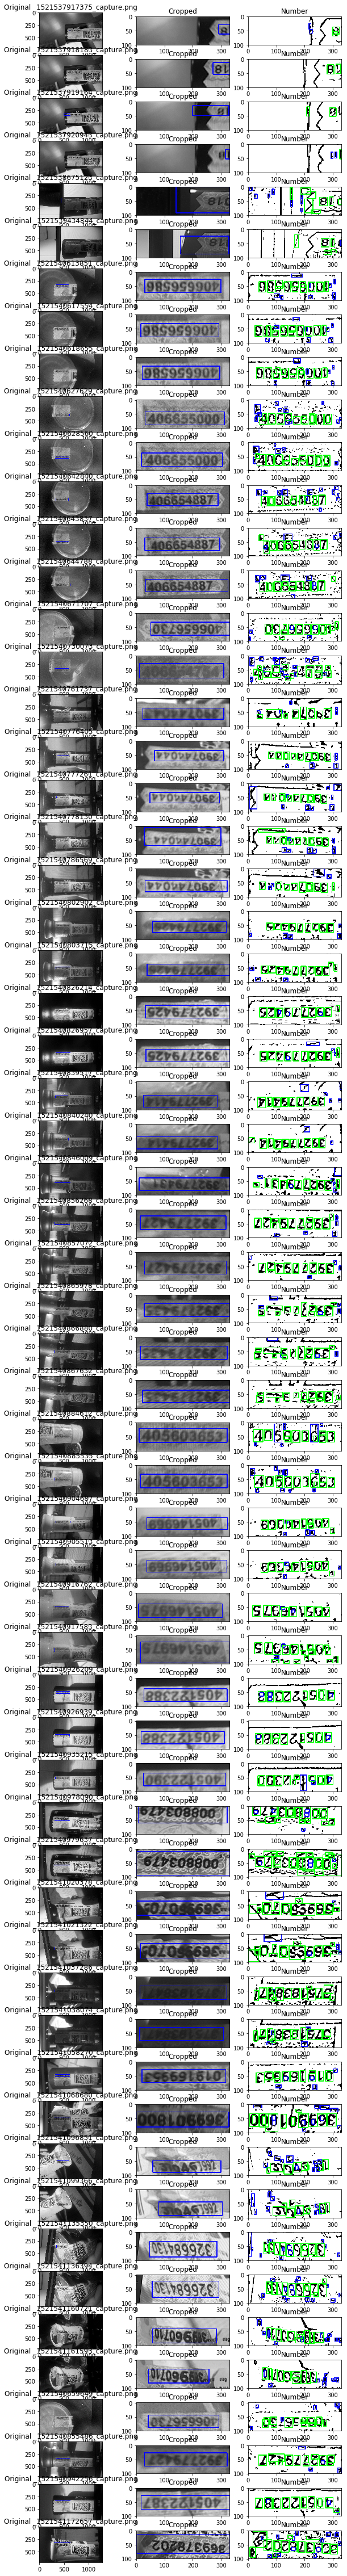

In [12]:
DIR = 'data/monitor'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 200))

for filename in tqdm(os.listdir(DIR)):
    if (not (filename.endswith(".PNG") or filename.endswith(".png"))) or (current_file_index > 60):
        current_file_index += 1
        continue

    current_input_src = cv2.imread(os.path.join(DIR, filename))

    cropped, number = segment_mumber(current_input_src)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(current_input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original ' + filename)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Cropped')
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')
    
    current_file_index += 1

plt.show()

100%|██████████| 146/146 [00:16<00:00,  8.62it/s]


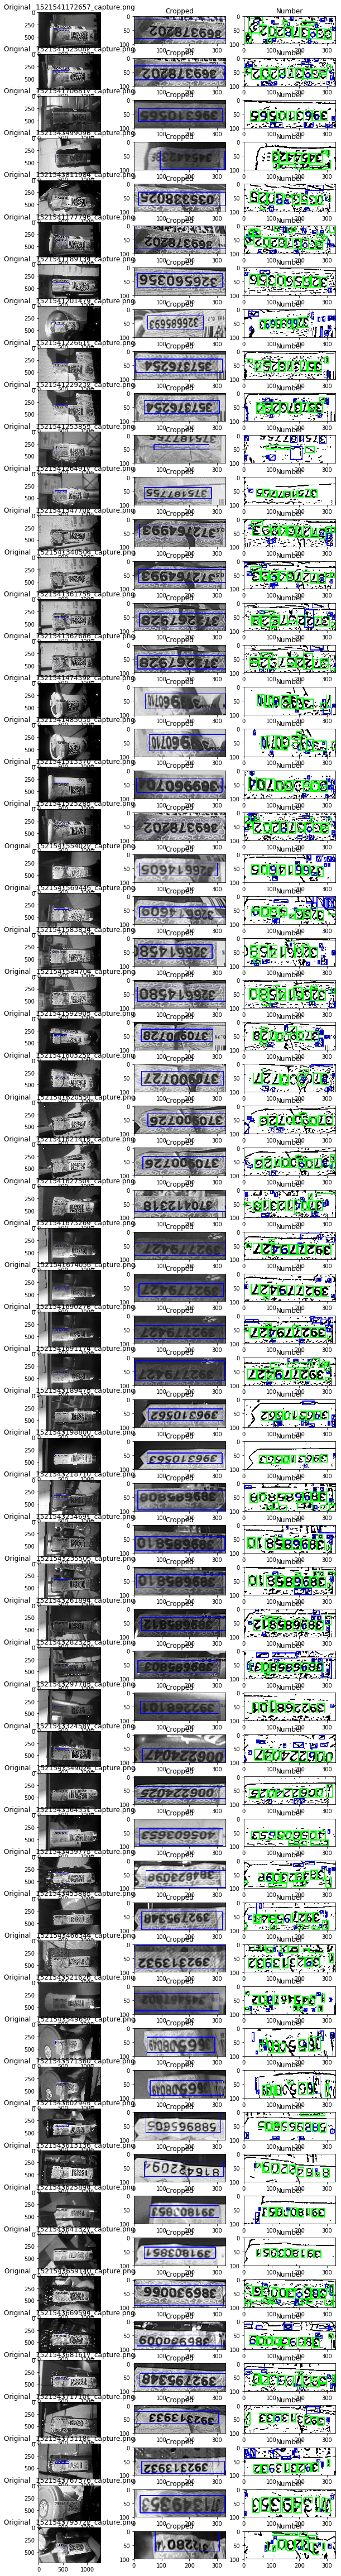

In [13]:
DIR = 'data/monitor'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 200))

for filename in tqdm(os.listdir(DIR)):
    if (not (filename.endswith(".PNG") or filename.endswith(".png"))) or (current_file_index > 120) or (current_file_index < 60):
        current_file_index += 1
        continue

    current_input_src = cv2.imread(os.path.join(DIR, filename))

    cropped, number = segment_mumber(current_input_src)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(current_input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original ' + filename)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Cropped')
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')
    
    current_file_index += 1

plt.show()

 94%|█████████▍| 137/146 [00:05<00:00, 10.45it/s] 


ValueError: num must be 1 <= num <= 435, not 436

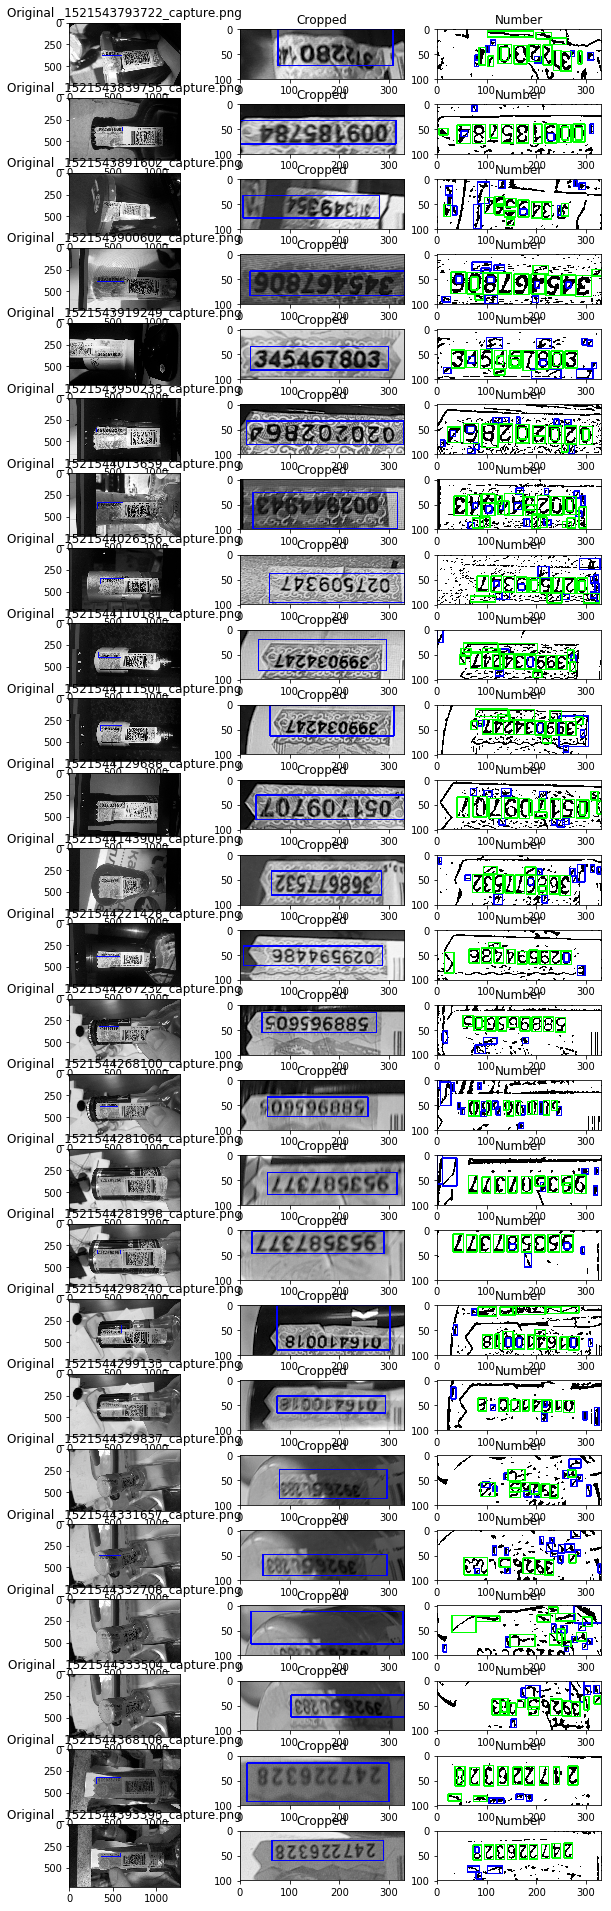

In [14]:
DIR = 'data/monitor'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 200))

for filename in tqdm(os.listdir(DIR)):
    if (not (filename.endswith(".PNG") or filename.endswith(".png"))) or (current_file_index < 120):
        current_file_index += 1
        continue

    current_input_src = cv2.imread(os.path.join(DIR, filename))

    cropped, number = segment_mumber(current_input_src)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(current_input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original ' + filename)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Cropped')
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')
    
    current_file_index += 1

plt.show()